In [2]:
%load_ext autoreload
%autoreload 2

import os
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import pytensor
from pytensor import tensor as T
from sklearn.preprocessing import scale, StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, leaves_list
import itertools
import pickle
import dill
from pyprojroot.here import here

In [3]:
here('submission/draft/survival_clustering.ipynb')

PosixPath('/Users/alzhang/Documents/projects/tfri_halo/submission/draft/survival_clustering.ipynb')

In [4]:
def create_trace_table(trace, export_variables = ['props', 'beta_clust', 'beta_stage', 'beta_age', 'beta_chemo', 'beta_rt', 'beta_brachy', 'beta_histotype']):
    # Create an empty list to store DataFrames
    export_dfs = []
    
    # Iterate over the list of column names
    for variable in export_variables:
        print(variable)
        posterior = trace.posterior[variable][0]
        
        if posterior.ndim == 2:
            posterior_clust_assignments = pd.DataFrame(posterior, columns=[f'{variable}_{i}' for i in range(posterior.shape[1])])
        elif posterior.ndim == 1:
            posterior_clust_assignments = pd.DataFrame(posterior, columns=[variable])
        else:
            print("Should not get here.")
        
        # Append the DataFrame to the list
        export_dfs.append(posterior_clust_assignments)
    
    # Concatenate the DataFrames horizontally (column bind)
    trace_table = pd.concat(export_dfs, axis=1)
    return trace_table

## Inputs

In [5]:
# Survival data, long format by outcome
clinical_long_full = pd.read_csv(here('results/survival_cluster/clinical_long.tsv'), sep='\t')

# Counts data, long format by TIL type and region
counts_long = pd.read_csv(here('results/survival_cluster/counts_final.tsv'), sep='\t')

In [6]:
counts_long = counts_long[counts_long['variable'].isin(['tcyto', 'thelper', 'treg', 'bcell_cd20pos', 'bcell_cd20neg', 'cd8tcell_foxp3pos'])].reset_index(drop=True)

In [7]:
counts_long

,acc_num,panel,variable,region,value,area_region_mm,density
0,00S-27016,B&T,bcell_cd20neg,stroma,2.0,0.071198,28.090636
1,00S-27016,B&T,bcell_cd20neg,tumour,0.0,0.481707,0.000000
2,00S-27016,B&T,bcell_cd20pos,stroma,6.0,0.071198,84.271909
3,00S-27016,B&T,bcell_cd20pos,tumour,3.0,0.481707,6.227850
4,00S-27016,B&T,cd8tcell_foxp3pos,stroma,0.0,0.071198,0.000000
...,...,...,...,...,...,...,...
4255,VS98-40754,B&T,tcyto,tumour,2.0,0.087467,22.865854
4256,VS98-40754,B&T,thelper,stroma,78.0,0.293635,265.636210
4257,VS98-40754,B&T,thelper,tumour,2.0,0.087467,22.865854
4258,VS98-40754,B&T,treg,stroma,13.0,0.293635,44.272702


In [8]:
# Filter for p53abn
clinical_long_full  = clinical_long_full.loc[clinical_long_full['eclass2_ngs'] == 'p53abn']
clinical_long = clinical_long_full.dropna()

eclass_encoder = LabelEncoder()
stage_encoder = LabelEncoder()

clinical_long['eclass2_ngs_idx'] = eclass_encoder.fit_transform(clinical_long['eclass2_ngs'])
clinical_long['stage_idx'] = stage_encoder.fit_transform(clinical_long['stage_main'])
clinical_long['carcinosarcoma'] = (clinical_long['hist_rev'] == 'carcinosarcoma (MMMT)').astype(int)
clinical_long['age_dx'] = scale(clinical_long['age_dx'], axis=0, with_mean=True, with_std=True, copy=True)

clinical_vars = ["acc_num", "outcome", "time", "status", "chemo", "rt", "brachy", "eclass2_ngs_idx", "stage_idx", "age_dx", "carcinosarcoma"]

clinical_selected = clinical_long[clinical_vars].drop_duplicates()

/var/folders/jc/22j_9txs7tsbytp_0w_497j00000gn/T/ipykernel_85437/2381075653.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_long['eclass2_ngs_idx'] = eclass_encoder.fit_transform(clinical_long['eclass2_ngs'])
/var/folders/jc/22j_9txs7tsbytp_0w_497j00000gn/T/ipykernel_85437/2381075653.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_long['stage_idx'] = stage_encoder.fit_transform(clinical_long['stage_main'])
/var/folders/jc/22j_9txs7tsbytp_0w_497j00000gn/T/ipykernel_85437/2381075653.

In [9]:
counts_long['variable_region'] = counts_long['variable'] + '_' + counts_long['region']

counts_wide = counts_long.pivot(index='acc_num', columns='variable_region', values='value').dropna()
areas_wide = counts_long.pivot(index='acc_num', columns='variable_region', values='area_region_mm').dropna()

In [10]:
# Accepts counts and areas in wide format, clinical data in long format
# Returns clinical data, areas, and counts indexed identically
def get_inputs(counts, areas, clinical, outcome):
    clinical = clinical[clinical['outcome'] == outcome].set_index('acc_num')
    
    common_samples = np.intersect1d(counts.index, clinical.index)
    counts = counts.loc[common_samples,:]
    areas = areas.loc[common_samples,:]
    clinical = clinical.loc[common_samples,:]

    return {'clinical': clinical, 'areas': areas, 'counts': counts}

In [11]:
# Output N x C (number of samples X number of region*cell types) counts array, with corresponding N x C area array
# Note that this is DIFFERENT from previous

os_inputs = get_inputs(counts_wide, areas_wide, clinical_selected, outcome = 'os')
pfs_inputs = get_inputs(counts_wide, areas_wide, clinical_selected, outcome = 'pfs')
dss_inputs = get_inputs(counts_wide, areas_wide, clinical_selected, outcome = 'dss')

# Going forward, we'll just cluster everything

counts_wide_all = counts_wide.loc[np.intersect1d(counts_wide.index, np.unique(clinical_long_full['acc_num'])),:]
areas_wide_all = areas_wide.loc[np.intersect1d(areas_wide.index, np.unique(clinical_long_full['acc_num'])),:]

In [12]:
## Full Bayesian model (including survival model, slow)
def fit_survcluster_model(inputs, nclusts = 2, ncenters = 20, interval_length = 0.3, epsilon = 1e-6, ndraw = 1000, ntune=1000, carcinosarcoma=False):
    count_mat = np.array(inputs['counts'])
    area_mat = np.array(inputs['areas'])
    clinical_df = inputs['clinical']
    time = clinical_df['time'].values
    event = clinical_df['status'].values
    stage = clinical_df['stage_idx'].values
    age = clinical_df['age_dx'].values
    chemo = clinical_df['chemo'].values.astype(int)
    rt = clinical_df['rt'].values.astype(int)
    brachy = clinical_df['brachy'].values.astype(int)

    if carcinosarcoma:
        histo = clinical_df['carcinosarcoma'].values.astype(int)
    
    nstages = len(np.unique(stage))
    ncelltypes = count_mat.shape[1]
    nsamples = count_mat.shape[0]
    
    mean_mu = np.sum(count_mat, axis = 0)/np.sum(area_mat, axis = 0)
    mean_mu = np.repeat(mean_mu[np.newaxis,:], nclusts, axis=0).transpose(0, 1)
    
    area_nonzero = area_mat + epsilon
    
    rbf_step = np.max(count_mat)/(ncenters-1.)
    centers = np.arange(ncenters) * rbf_step
    
    # intervals 
    
    samples = np.arange(nsamples)
    interval_bounds = np.arange(0, time.max() + interval_length + 1, interval_length)
    
    nintervals = interval_bounds.size - 1
    intervals = np.arange(nintervals)
    
    last_period = np.floor((time - 0.01) / interval_length).astype(int)
    
    death = np.zeros((nsamples, nintervals))
    death[samples, last_period] = event
    
    exposure = np.greater_equal.outer(time, interval_bounds[:-1]) * interval_length
    exposure[samples, last_period] = time - interval_bounds[last_period]
    
    coords = {"intervals": intervals}

    with pm.Model(coords = coords) as survival_mixture_model:
        # Priors for survival coefficients
        
        beta_clust0 = pm.Normal("beta_clust0", mu=0, sigma=5, shape=nclusts-1)
        beta_clust = pm.Deterministic("beta_clust", pm.math.concatenate([[0], beta_clust0]))
        beta_stage0 = pm.Normal("beta_stage0", mu=0, sigma=5, shape=nstages-1)
        beta_stage = pm.Deterministic("beta_stage", pm.math.concatenate([[0], beta_stage0]))
        beta_age = pm.Normal("beta_age", mu=0, sigma=5)
        beta_chemo = pm.Normal("beta_chemo", mu = 0, sigma = 5)
        beta_rt = pm.Normal("beta_rt", mu = 0, sigma = 5)
        beta_brachy = pm.Normal("beta_brachy", mu = 0, sigma = 5)
        if carcinosarcoma:
            beta_histo = pm.Normal("beta_histo", mu = 0, sigma = 5)
    
        # Priors for count coefficient
        mu_clust = pm.Gamma("mu_clust", mu = mean_mu, sigma = 100, shape = (nclusts, ncelltypes))
        
        # Latent categorical variable for 'clust'
        props = pm.Dirichlet('props', np.ones(nclusts))
        clust = pm.Categorical("clust", p=props, shape=nsamples)
    
        # NB distribution for count data using adjusted area and mu_clust
        count_mu = area_nonzero * mu_clust[clust]  # Use 'area' as multiplier
    
        # RBF based NB dispersion 
        theta_a = pm.Normal("theta_a", mu = 0, sigma=1, shape=ncenters)
        theta_b = pm.Normal("theta_b", mu = 0, sigma=1, shape=ncenters)
        count_disp = T.dot(T.exp(-T.exp(theta_b) * (T.reshape(T.repeat(count_mu, repeats=ncenters), newshape=(nsamples, ncelltypes, ncenters)) - centers[np.newaxis, np.newaxis, :])**2), T.exp(theta_a)) + epsilon
    
        # Likelihood for count data
        count_v = pm.NegativeBinomial("count_v", mu=count_mu, alpha=count_disp, observed=count_mat)
        
        # Don't forget lambda_0 AFTERWARDS ADD THIS -- need to fix intercepts and dimensions as a result
        lambda0 = pm.Gamma("lambda0", 0.1, 0.1, dims = "intervals") # 0.01, 0.05, 0.1
        
        # Linear predictor for Cox PH model
        linear_predictor = (
            beta_clust[clust]
            + beta_stage[stage]
            + beta_age * age
            + beta_chemo * chemo
            + beta_rt * rt
            + beta_brachy * brachy
        )

        if carcinosarcoma:
            linear_predictor = linear_predictor + beta_histo * histo
    
    
        lambda_ = pm.Deterministic("lambda_", T.outer(T.exp(linear_predictor), lambda0))
    
        mu = pm.Deterministic("mu", exposure * lambda_)
    
        # Poisson-Cox PH equivalence
        obs = pm.Poisson("obs", mu=mu, observed=death)
    
        survival_mixture_model.debug(verbose = True)
    
        trace = pm.sample(ndraw, tune=ntune, chains=1, progressbar=True)

        return {'trace': trace, 'model': survival_mixture_model}

In [13]:
## Bayesian mixture model, no survival component
def fit_simple_survcluster_model(counts, areas, nclusts = 2, ncenters = 20, epsilon = 1e-6, ndraw = 1000, ntune=1000):
    count_mat = np.array(counts)
    area_mat = np.array(areas)
    
    ncelltypes = count_mat.shape[1]
    nsamples = count_mat.shape[0]
    
    mean_mu = np.sum(count_mat, axis = 0)/np.sum(area_mat, axis = 0)
    mean_mu = np.repeat(mean_mu[np.newaxis,:], nclusts, axis=0).transpose(0, 1)
    
    area_nonzero = area_mat + epsilon
    
    rbf_step = np.max(count_mat)/(ncenters-1.)
    centers = np.arange(ncenters) * rbf_step
    
    # intervals 
    
    samples = np.arange(nsamples)

    with pm.Model() as survival_mixture_model:
        # Priors for count coefficient
        mu_clust = pm.Gamma("mu_clust", mu = mean_mu, sigma = 100, shape = (nclusts, ncelltypes))
        
        # Latent categorical variable for 'clust'
        props = pm.Dirichlet('props', np.ones(nclusts))
        clust = pm.Categorical("clust", p=props, shape=nsamples)
    
        # NB distribution for count data using adjusted area and mu_clust
        count_mu = area_nonzero * mu_clust[clust]  # Use 'area' as multiplier
    
        # RBF based NB dispersion 
        theta_a = pm.Normal("theta_a", mu = 0, sigma=1, shape=ncenters)
        theta_b = pm.Normal("theta_b", mu = 0, sigma=1, shape=ncenters)
        count_disp = T.dot(T.exp(-T.exp(theta_b) * (T.reshape(T.repeat(count_mu, repeats=ncenters), newshape=(nsamples, ncelltypes, ncenters)) - centers[np.newaxis, np.newaxis, :])**2), T.exp(theta_a)) + epsilon
    
        # Likelihood for count data
        count_v = pm.NegativeBinomial("count_v", mu=count_mu, alpha=count_disp, observed=count_mat)
    
        survival_mixture_model.debug(verbose = True)
    
        trace = pm.sample(ndraw, tune=ntune, chains=1, progressbar=True)

        return {'trace': trace, 'model': survival_mixture_model}

In [14]:
## Dirichlet process prior with clustering model (slow)
def stick_breaking(beta):
    portion_remaining = T.concatenate([[1], T.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

def fit_dpm_survcluster_model(counts, areas, K = 10, ncenters = 20, epsilon = 1e-6, rate = 1.0, ndraw = 1000, ntune=1000, sampler = "nutpie"):
    count_mat = np.array(counts)
    area_mat = np.array(areas)
    
    ncelltypes = count_mat.shape[1]
    nsamples = count_mat.shape[0]
    
    mean_mu = np.sum(count_mat, axis = 0)/np.sum(area_mat, axis = 0)
    mean_mu = np.repeat(mean_mu[np.newaxis,:], K, axis=0).transpose(0, 1)
    
    area_nonzero = area_mat + epsilon
    
    rbf_step = np.max(count_mat)/(ncenters-1.)
    centers = np.arange(ncenters) * rbf_step
    
    # intervals 
    
    samples = np.arange(nsamples)

    with pm.Model(coords={"component": np.arange(K)}) as survival_mixture_model:
        alpha = pm.Gamma("alpha", 1.0, rate) #1.0) # Encourage sparsity
        beta = pm.Beta("beta", 1.0, alpha, dims="component")
        w = pm.Deterministic("w", stick_breaking(beta)/T.sum(stick_breaking(beta)), dims = "component")

        print(w.eval())
        print(w.shape.eval())
        
        # Priors for count coefficient
        mu_clust = pm.Gamma("mu_clust", mu = mean_mu, sigma = 100, shape = (K, ncelltypes))
        mu_clust2 = T.transpose(T.reshape(T.repeat(mu_clust, repeats = nsamples), newshape=(K, ncelltypes, nsamples)), axes=(0, 2, 1))
        mu_clust3 = mu_clust2 * area_nonzero
        
        # Latent categorical variable for 'clust'
        #props = pm.Dirichlet('props', np.ones(nclusts))
        #clust = pm.Categorical("clust", p=props, shape=nsamples)
    
        # NB distribution for count data using adjusted area and mu_clust
        #count_mu = area_nonzero * mu_clust[clust]  # Use 'area' as multiplier
        
        # RBF based NB dispersion 
        theta_a = pm.Normal("theta_a", mu = 0, sigma=1, shape=ncenters)
        theta_b = pm.Normal("theta_b", mu = 0, sigma=1, shape=ncenters)
        count_disp = T.dot(T.exp(-T.exp(theta_b) * (T.reshape(T.repeat(mu_clust3, repeats=ncenters), newshape=(K, nsamples, ncelltypes, ncenters)) - centers[np.newaxis, np.newaxis, np.newaxis, :])**2), T.exp(theta_a)) + epsilon
        print(mu_clust3.eval())
        
        # Likelihood for count data
        components = pm.NegativeBinomial.dist(mu=T.transpose(mu_clust3, (1, 2, 0)), alpha=T.transpose(count_disp, (1, 2, 0)))

        print(components.shape.eval())
        
        pm.Mixture('obs', w=w, comp_dists=components, observed=count_mat)
        #count_v = pm.NegativeBinomial("count_v", mu=mu_clust, alpha=count_disp, observed=count_mat)
    
        survival_mixture_model.debug(verbose = True)
    
        trace = pm.sample(ndraw, tune=ntune, chains=1, progressbar=True, nuts_sampler= sampler)

        return {'trace': trace, 'model': survival_mixture_model}

In [105]:
os_outputs = fit_survcluster_model(os_inputs, nclusts = 2, ncenters = 20, interval_length = 0.3, epsilon = 1e-6, ndraw = 2000, ntune=1000)

point={'beta_clust0': array([0.]), 'beta_stage0': array([0., 0., 0.]), 'beta_age': array(0.), 'beta_chemo': array(0.), 'beta_rt': array(0.), 'beta_brachy': array(0.), 'mu_clust_log__': array([[5.77459069, 2.42520199, 4.47969815, 1.27494672, 2.59042134,
        0.99876671, 6.14127519, 4.44956447, 6.12120426, 3.86357817,
        5.22704515, 2.76775106],
       [5.77459069, 2.42520199, 4.47969815, 1.27494672, 2.59042134,
        0.99876671, 6.14127519, 4.44956447, 6.12120426, 3.86357817,
        5.22704515, 2.76775106]]), 'props_simplex__': array([0.]), 'clust': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [beta_clust0, beta_stage0, beta_age, beta_chemo, beta_rt, beta_brachy, mu_clust, props, theta_a, theta_b, lambda0]
>BinaryGibbsMetropolis: [clust]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 797 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [122]:
pm.summary(os_outputs['trace'], var_names=["props", "beta_clust", "beta_stage", "beta_age", "beta_chemo", "beta_rt", "beta_brachy"])

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
props[0],0.470,0.035,0.406,0.535,0.001,0.001,1146.0,1424.0,NaN
props[1],0.530,0.035,0.465,0.594,0.001,0.001,1146.0,1424.0,NaN
beta_clust[0],0.000,0.000,0.000,0.000,0.000,0.000,2000.0,2000.0,NaN
beta_clust[1],-0.456,0.239,-0.915,-0.018,0.008,0.006,819.0,977.0,NaN
beta_stage[0],0.000,0.000,0.000,0.000,0.000,0.000,2000.0,2000.0,NaN
beta_stage[1],0.742,0.694,-0.529,2.065,0.021,0.014,1196.0,1184.0,NaN
beta_stage[2],1.118,0.324,0.479,1.681,0.010,0.007,1152.0,1359.0,NaN
beta_stage[3],2.908,0.447,2.107,3.796,0.017,0.012,697.0,1033.0,NaN
beta_age,0.192,0.122,-0.041,0.409,0.004,0.002,1197.0,1324.0,NaN
beta_chemo,-0.896,0.333,-1.514,-0.295,0.010,0.007,1084.0,1276.0,NaN


In [65]:
# Dirichlet model
dpm_output = fit_dpm_survcluster_model(os_inputs, K = 10, ncenters = 20, epsilon = 1e-6, ndraw = 500, ntune=500)

[9.99993129e-01 6.86360037e-06 4.74429543e-09 2.26517933e-09
 1.36389342e-17 1.19607215e-22 2.38498974e-31 3.18860010e-41
 0.00000000e+00 0.00000000e+00]
[10]
[[[6.22625231e+01 5.07672497e-10 5.23494977e-01 ... 1.42920144e-01
   2.37184713e+01 9.31572800e-14]
  [2.57174837e+01 6.99503633e-10 2.16229167e-01 ... 1.96924515e-01
   9.79689495e+00 1.28358058e-13]
  [3.61428400e+01 7.10809796e-10 3.03884171e-01 ... 2.00107430e-01
   1.37683613e+01 1.30432725e-13]
  ...
  [6.28062546e+01 9.89428100e-10 5.28066599e-01 ... 2.78544155e-01
   2.39256020e+01 1.81558842e-13]
  [1.17943069e+02 6.50691901e-10 9.91649572e-01 ... 1.83183018e-01
   4.49295847e+01 1.19401165e-13]
  [2.82758286e+01 9.79500791e-10 2.37739390e-01 ... 2.75749415e-01
   1.07714785e+01 1.79737193e-13]]

 [[7.25895306e+01 3.17440955e-24 1.63480492e+01 ... 2.53108251e+01
   1.40668381e+01 3.59018965e-06]
  [2.99830456e+01 4.37390448e-24 6.75254820e+00 ... 3.48748734e+01
   5.81029585e+00 4.94679289e-06]
  [4.21375759e+01 4.44460

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha, beta, mu_clust, theta_a, theta_b]


Sampling 1 chain for 500 tune and 500 draw iterations (500 + 500 draws total) took 5675 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [20]:
pm.summary(dpm_output['trace'], var_names=["w", "alpha"])

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],0.588,0.040,0.512,0.656,0.011,0.008,14.0,36.0,NaN
w[1],0.347,0.033,0.289,0.407,0.007,0.005,23.0,35.0,NaN
w[2],0.038,0.021,0.004,0.076,0.005,0.003,19.0,48.0,NaN
w[3],0.020,0.023,0.001,0.065,0.009,0.007,3.0,21.0,NaN
w[4],0.005,0.007,0.000,0.014,0.002,0.001,8.0,32.0,NaN
w[5],0.001,0.001,0.000,0.004,0.000,0.000,25.0,61.0,NaN
w[6],0.001,0.001,0.000,0.002,0.000,0.000,52.0,79.0,NaN
w[7],0.000,0.001,0.000,0.001,0.000,0.000,20.0,63.0,NaN
w[8],0.000,0.000,0.000,0.000,0.000,0.000,24.0,73.0,NaN
w[9],0.000,0.000,0.000,0.000,0.000,0.000,27.0,85.0,NaN


array([[<Axes: title={'center': 'w'}>, <Axes: title={'center': 'w'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

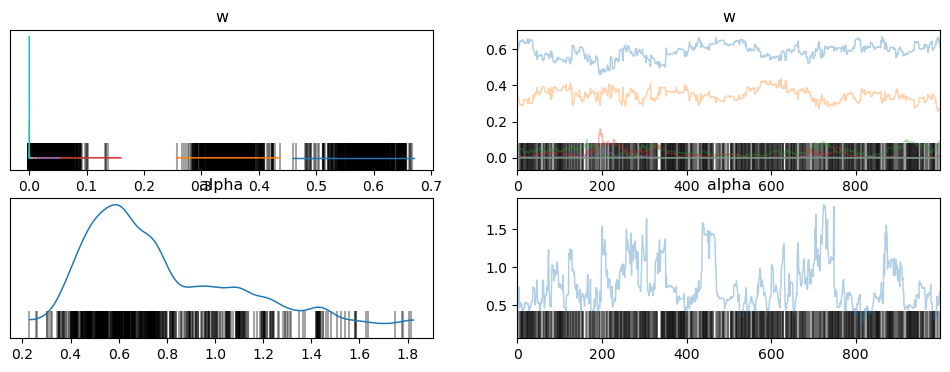

In [29]:
pm.plot_trace(dpm_output['trace'], var_names=["w", "alpha"])

In [68]:
pfs_outputs = fit_survcluster_model(pfs_inputs, nclusts = 2, ncenters = 20, interval_length = 0.3, epsilon = 1e-6, ndraw = 2000, ntune=1000)

point={'beta_clust0': array([0.]), 'beta_stage0': array([0., 0., 0.]), 'beta_age': array(0.), 'beta_chemo': array(0.), 'beta_rt': array(0.), 'beta_brachy': array(0.), 'mu_clust_log__': array([[5.72015733, 2.29265387, 4.4978472 , 1.22928752, 2.60791631,
        1.01154063, 6.160087  , 4.39980945, 6.13320176, 3.83450727,
        5.23513553, 2.77010355],
       [5.72015733, 2.29265387, 4.4978472 , 1.22928752, 2.60791631,
        1.01154063, 6.160087  , 4.39980945, 6.13320176, 3.83450727,
        5.23513553, 2.77010355]]), 'props_simplex__': array([0.]), 'clust': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [beta_clust0, beta_stage0, beta_age, beta_chemo, beta_rt, beta_brachy, mu_clust, props, theta_a, theta_b, lambda0]
>BinaryGibbsMetropolis: [clust]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 479 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [124]:
pm.summary(pfs_outputs['trace'], var_names=["props", "beta_clust", "beta_stage", "beta_age", "beta_chemo", "beta_rt", "beta_brachy"])

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
props[0],0.456,0.036,0.392,0.525,0.001,0.001,1273.0,1301.0,NaN
props[1],0.544,0.036,0.475,0.608,0.001,0.001,1273.0,1301.0,NaN
beta_clust[0],0.000,0.000,0.000,0.000,0.000,0.000,2000.0,2000.0,NaN
beta_clust[1],-0.378,0.228,-0.791,0.043,0.007,0.005,1222.0,1337.0,NaN
beta_stage[0],0.000,0.000,0.000,0.000,0.000,0.000,2000.0,2000.0,NaN
beta_stage[1],-0.348,0.807,-1.915,1.050,0.021,0.019,1528.0,1095.0,NaN
beta_stage[2],1.383,0.283,0.862,1.927,0.009,0.006,1023.0,1137.0,NaN
beta_stage[3],2.719,0.390,1.968,3.425,0.013,0.009,955.0,1247.0,NaN
beta_age,-0.018,0.119,-0.250,0.186,0.003,0.003,1720.0,1229.0,NaN
beta_chemo,-0.447,0.310,-1.082,0.090,0.010,0.007,885.0,797.0,NaN


In [28]:
dss_outputs = fit_survcluster_model(dss_inputs, nclusts = 2, ncenters = 20, interval_length = 0.3, epsilon = 1e-6, ndraw = 2000, ntune=1000)

point={'beta_clust0': array([0.]), 'beta_stage0': array([0., 0., 0.]), 'beta_age': array(0.), 'beta_chemo': array(0.), 'beta_rt': array(0.), 'beta_brachy': array(0.), 'mu_clust_log__': array([[5.79532401, 2.36757235, 4.4788403 , 1.29053766, 6.14885985,
        4.44865544, 6.12517763, 3.84628732, 5.23724101, 2.77098464],
       [5.79532401, 2.36757235, 4.4788403 , 1.29053766, 6.14885985,
        4.44865544, 6.12517763, 3.84628732, 5.23724101, 2.77098464]]), 'props_simplex__': array([0.]), 'clust': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [beta_clust0, beta_stage0, beta_age, beta_chemo, beta_rt, beta_brachy, mu_clust, props, theta_a, theta_b, lambda0]
>BinaryGibbsMetropolis: [clust]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 422 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [126]:
pm.summary(dss_outputs['trace'], var_names=["props", "beta_clust", "beta_stage", "beta_age", "beta_chemo", "beta_rt", "beta_brachy"])

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
props[0],0.467,0.038,0.402,0.543,0.001,0.001,1576.0,785.0,NaN
props[1],0.533,0.038,0.457,0.598,0.001,0.001,1576.0,785.0,NaN
beta_clust[0],0.000,0.000,0.000,0.000,0.000,0.000,2000.0,2000.0,NaN
beta_clust[1],-0.587,0.294,-1.169,-0.087,0.007,0.006,1545.0,1254.0,NaN
beta_stage[0],0.000,0.000,0.000,0.000,0.000,0.000,2000.0,2000.0,NaN
beta_stage[1],0.062,1.315,-2.435,2.273,0.035,0.032,1664.0,1102.0,NaN
beta_stage[2],1.630,0.425,0.878,2.466,0.011,0.008,1587.0,1332.0,NaN
beta_stage[3],3.413,0.519,2.488,4.410,0.015,0.010,1244.0,1126.0,NaN
beta_age,0.061,0.147,-0.182,0.366,0.003,0.003,2016.0,1180.0,NaN
beta_chemo,-0.959,0.420,-1.740,-0.178,0.010,0.007,1643.0,1277.0,NaN


## Output traces

In [21]:
def create_trace_table(trace, export_variables = ['props', 'beta_clust', 'beta_stage', 'beta_age', 'beta_chemo', 'beta_rt', 'beta_brachy']):
    # Create an empty list to store DataFrames
    export_dfs = []
    
    # Iterate over the list of column names
    for variable in export_variables:
        #print(variable)
        posterior = trace.posterior[variable][0]
        
        if posterior.ndim == 2:
            posterior_clust_assignments = pd.DataFrame(posterior, columns=[f'{variable}_{i}' for i in range(posterior.shape[1])])
        elif posterior.ndim == 1:
            posterior_clust_assignments = pd.DataFrame(posterior, columns=[variable])
        else:
            print("Should not get here.")
        
        # Append the DataFrame to the list
        export_dfs.append(posterior_clust_assignments)
    
    # Concatenate the DataFrames horizontally (column bind)
    trace_table = pd.concat(export_dfs, axis=1)
    return trace_table

def extract_cluster_assignments(trace, sample_names):
    cluster_df = pd.DataFrame(trace.posterior['clust'][0].T)
    cluster_df.index = sample_names
    return cluster_df.reset_index()

In [33]:
dirichlet_process_trace = create_trace_table(dpm_output['trace'], export_variables = ['w', 'alpha', 'beta', 'theta_a', 'theta_b'])
overall_trace_table = create_trace_table(outputs_simple['trace'], export_variables = ['props'])
overall_cluster_assignments = extract_cluster_assignments(outputs_simple['trace'], sample_names = counts_wide_all.index)

trace_agg_output_dir = here('results/survival_cluster/traces_aggregate')

dirichlet_process_trace.to_csv(os.path.join(trace_agg_output_dir, 'dp_trace_table.tsv'), sep='\t')
overall_trace_table.to_csv(os.path.join(trace_agg_output_dir, 'overall_trace_table.tsv'), sep='\t')
overall_cluster_assignments.to_csv(os.path.join(trace_agg_output_dir, 'overall_cluster_assignments.tsv'), sep='\t')
outputs_simple['trace'].to_netcdf(os.path.join(trace_agg_output_dir, 'overall_trace.nc'))
dpm_output['trace'].to_netcdf(os.path.join(trace_agg_output_dir, 'dp_trace.nc'))

'/Users/alzhang/Documents/projects/tfri_halo/results/survival_cluster/traces_aggregate/dp_trace.nc'

In [128]:
os_trace_table = create_trace_table(os_outputs['trace'])
os_cluster_assignments = extract_cluster_assignments(os_outputs['trace'], sample_names = os_inputs['counts'].index)

pfs_trace_table = create_trace_table(pfs_outputs['trace'])
pfs_cluster_assignments = extract_cluster_assignments(pfs_outputs['trace'], sample_names = pfs_inputs['counts'].index)

dss_trace_table = create_trace_table(dss_outputs['trace'])
dss_cluster_assignments = extract_cluster_assignments(dss_outputs['trace'], sample_names = dss_inputs['counts'].index)

In [129]:
trace_output_dir = here('results/survival_cluster/traces')
#model_output_dir = here('results/survival_cluster/models')

os_trace_table.to_csv(os.path.join(trace_output_dir, 'os_trace_table.tsv'), sep='\t')
os_cluster_assignments.to_csv(os.path.join(trace_output_dir, 'os_cluster_assignments.tsv'), sep='\t')

pfs_trace_table.to_csv(os.path.join(trace_output_dir, 'pfs_trace_table.tsv'), sep='\t')
pfs_cluster_assignments.to_csv(os.path.join(trace_output_dir, 'pfs_cluster_assignments.tsv'), sep='\t')

dss_trace_table.to_csv(os.path.join(trace_output_dir, 'dss_trace_table.tsv'), sep='\t')
dss_cluster_assignments.to_csv(os.path.join(trace_output_dir, 'dss_cluster_assignments.tsv'), sep='\t')

# Output arviz inferencedata objects
os_outputs['trace'].to_netcdf(os.path.join(trace_output_dir, 'os_results.nc'))
pfs_outputs['trace'].to_netcdf(os.path.join(trace_output_dir, 'pfs_results.nc'))
dss_outputs['trace'].to_netcdf(os.path.join(trace_output_dir, 'dss_results.nc'))

'/Users/alzhang/Documents/projects/tfri_halo/results/survival_cluster/traces/dss_results.nc'

## Carcinosarcoma analysis

In [137]:
os_outputs_cs = fit_survcluster_model(os_inputs, nclusts = 2, ncenters = 20, interval_length = 0.3, epsilon = 1e-6, ndraw = 2000, ntune=1000, carcinosarcoma=True)

point={'beta_clust0': array([0.]), 'beta_stage0': array([0., 0., 0.]), 'beta_age': array(0.), 'beta_chemo': array(0.), 'beta_rt': array(0.), 'beta_brachy': array(0.), 'beta_histo': array(0.), 'mu_clust_log__': array([[5.77459069, 2.42520199, 4.47969815, 1.27494672, 2.59042134,
        0.99876671, 6.14127519, 4.44956447, 6.12120426, 3.86357817,
        5.22704515, 2.76775106],
       [5.77459069, 2.42520199, 4.47969815, 1.27494672, 2.59042134,
        0.99876671, 6.14127519, 4.44956447, 6.12120426, 3.86357817,
        5.22704515, 2.76775106]]), 'props_simplex__': array([0.]), 'clust': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [beta_clust0, beta_stage0, beta_age, beta_chemo, beta_rt, beta_brachy, beta_histo, mu_clust, props, theta_a, theta_b, lambda0]
>BinaryGibbsMetropolis: [clust]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 814 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [139]:
pm.summary(os_outputs_cs['trace'], var_names=["props", "beta_clust", "beta_stage", "beta_age", "beta_chemo", "beta_rt", "beta_brachy", "beta_histo"])

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
props[0],0.468,0.035,0.401,0.529,0.001,0.001,1598.0,1178.0,NaN
props[1],0.532,0.035,0.471,0.599,0.001,0.001,1598.0,1178.0,NaN
beta_clust[0],0.000,0.000,0.000,0.000,0.000,0.000,2000.0,2000.0,NaN
beta_clust[1],-0.423,0.239,-0.921,-0.018,0.008,0.005,971.0,1243.0,NaN
beta_stage[0],0.000,0.000,0.000,0.000,0.000,0.000,2000.0,2000.0,NaN
beta_stage[1],0.751,0.710,-0.519,2.109,0.019,0.014,1417.0,995.0,NaN
beta_stage[2],1.114,0.325,0.509,1.717,0.009,0.007,1234.0,1244.0,NaN
beta_stage[3],2.906,0.429,2.137,3.747,0.014,0.010,998.0,1169.0,NaN
beta_age,0.201,0.123,-0.026,0.433,0.003,0.003,1642.0,1085.0,NaN
beta_chemo,-0.865,0.324,-1.453,-0.243,0.009,0.006,1321.0,1398.0,NaN


In [140]:
pfs_outputs_cs = fit_survcluster_model(pfs_inputs, nclusts = 2, ncenters = 20, interval_length = 0.3, epsilon = 1e-6, ndraw = 2000, ntune=1000, carcinosarcoma=True)

point={'beta_clust0': array([0.]), 'beta_stage0': array([0., 0., 0.]), 'beta_age': array(0.), 'beta_chemo': array(0.), 'beta_rt': array(0.), 'beta_brachy': array(0.), 'beta_histo': array(0.), 'mu_clust_log__': array([[5.72015733, 2.29265387, 4.4978472 , 1.22928752, 2.60791631,
        1.01154063, 6.160087  , 4.39980945, 6.13320176, 3.83450727,
        5.23513553, 2.77010355],
       [5.72015733, 2.29265387, 4.4978472 , 1.22928752, 2.60791631,
        1.01154063, 6.160087  , 4.39980945, 6.13320176, 3.83450727,
        5.23513553, 2.77010355]]), 'props_simplex__': array([0.]), 'clust': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [beta_clust0, beta_stage0, beta_age, beta_chemo, beta_rt, beta_brachy, beta_histo, mu_clust, props, theta_a, theta_b, lambda0]
>BinaryGibbsMetropolis: [clust]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 931 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [141]:
pm.summary(pfs_outputs_cs['trace'], var_names=["props", "beta_clust", "beta_stage", "beta_age", "beta_chemo", "beta_rt", "beta_brachy", "beta_histo"])

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
props[0],0.458,0.035,0.394,0.523,0.001,0.001,1133.0,810.0,NaN
props[1],0.542,0.035,0.477,0.606,0.001,0.001,1133.0,810.0,NaN
beta_clust[0],0.000,0.000,0.000,0.000,0.000,0.000,2000.0,2000.0,NaN
beta_clust[1],-0.342,0.240,-0.795,0.088,0.008,0.006,848.0,1065.0,NaN
beta_stage[0],0.000,0.000,0.000,0.000,0.000,0.000,2000.0,2000.0,NaN
beta_stage[1],-0.336,0.825,-1.904,1.143,0.026,0.021,1093.0,957.0,NaN
beta_stage[2],1.404,0.298,0.841,1.962,0.011,0.008,748.0,686.0,NaN
beta_stage[3],2.710,0.404,1.957,3.453,0.014,0.010,815.0,1185.0,NaN
beta_age,-0.010,0.118,-0.216,0.224,0.003,0.003,1152.0,775.0,NaN
beta_chemo,-0.436,0.328,-1.011,0.189,0.012,0.008,787.0,895.0,NaN


In [158]:
dss_outputs_cs = fit_survcluster_model(dss_inputs, nclusts = 2, ncenters = 20, interval_length = 0.3, epsilon = 1e-6, ndraw = 2000, ntune=1000, carcinosarcoma=True)

point={'beta_clust0': array([0.]), 'beta_stage0': array([0., 0., 0.]), 'beta_age': array(0.), 'beta_chemo': array(0.), 'beta_rt': array(0.), 'beta_brachy': array(0.), 'beta_histo': array(0.), 'mu_clust_log__': array([[5.79532401, 2.36757235, 4.4788403 , 1.29053766, 2.60655445,
        1.02825549, 6.14885985, 4.44865544, 6.12517763, 3.84628732,
        5.23724101, 2.77098464],
       [5.79532401, 2.36757235, 4.4788403 , 1.29053766, 2.60655445,
        1.02825549, 6.14885985, 4.44865544, 6.12517763, 3.84628732,
        5.23724101, 2.77098464]]), 'props_simplex__': array([0.]), 'clust': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [beta_clust0, beta_stage0, beta_age, beta_chemo, beta_rt, beta_brachy, beta_histo, mu_clust, props, theta_a, theta_b, lambda0]
>BinaryGibbsMetropolis: [clust]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 6216 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [161]:
pm.summary(dss_outputs_cs['trace'], var_names=["props", "beta_clust", "beta_stage", "beta_age", "beta_chemo", "beta_rt", "beta_brachy", "beta_histo"])

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
props[0],0.470,0.036,0.406,0.541,0.001,0.001,1142.0,1233.0,NaN
props[1],0.530,0.036,0.459,0.594,0.001,0.001,1142.0,1233.0,NaN
beta_clust[0],0.000,0.000,0.000,0.000,0.000,0.000,2000.0,2000.0,NaN
beta_clust[1],-0.543,0.303,-1.154,-0.020,0.010,0.007,1012.0,1154.0,NaN
beta_stage[0],0.000,0.000,0.000,0.000,0.000,0.000,2000.0,2000.0,NaN
beta_stage[1],0.066,1.314,-2.323,2.369,0.046,0.036,915.0,758.0,NaN
beta_stage[2],1.640,0.418,0.861,2.419,0.014,0.010,880.0,1077.0,NaN
beta_stage[3],3.432,0.554,2.395,4.460,0.020,0.014,811.0,898.0,NaN
beta_age,0.059,0.149,-0.215,0.350,0.005,0.004,1070.0,1051.0,NaN
beta_chemo,-0.963,0.419,-1.722,-0.192,0.014,0.010,937.0,1065.0,NaN


In [162]:
os_trace_table_cs = create_trace_table(os_outputs_cs['trace'])
os_cluster_assignments_cs = extract_cluster_assignments(os_outputs_cs['trace'], sample_names = os_inputs['counts'].index)

pfs_trace_table_cs = create_trace_table(pfs_outputs_cs['trace'])
pfs_cluster_assignments_cs = extract_cluster_assignments(pfs_outputs_cs['trace'], sample_names = pfs_inputs['counts'].index)

dss_trace_table_cs = create_trace_table(dss_outputs_cs['trace'])
dss_cluster_assignments_cs = extract_cluster_assignments(dss_outputs_cs['trace'], sample_names = dss_inputs['counts'].index)

trace_output_dir = here('results/survival_cluster/traces_carcinosarcoma')
#model_output_dir = here('results/survival_cluster/models')

os_trace_table_cs.to_csv(os.path.join(trace_output_dir, 'os_trace_table.tsv'), sep='\t')
os_cluster_assignments_cs.to_csv(os.path.join(trace_output_dir, 'os_cluster_assignments.tsv'), sep='\t')

pfs_trace_table_cs.to_csv(os.path.join(trace_output_dir, 'pfs_trace_table.tsv'), sep='\t')
pfs_cluster_assignments_cs.to_csv(os.path.join(trace_output_dir, 'pfs_cluster_assignments.tsv'), sep='\t')

dss_trace_table_cs.to_csv(os.path.join(trace_output_dir, 'dss_trace_table.tsv'), sep='\t')
dss_cluster_assignments_cs.to_csv(os.path.join(trace_output_dir, 'dss_cluster_assignments.tsv'), sep='\t')

# Output arviz inferencedata objects
os_outputs_cs['trace'].to_netcdf(os.path.join(trace_output_dir, 'os_results.nc'))
pfs_outputs_cs['trace'].to_netcdf(os.path.join(trace_output_dir, 'pfs_results.nc'))
dss_outputs_cs['trace'].to_netcdf(os.path.join(trace_output_dir, 'dss_results.nc'))

'/Users/alzhang/Documents/projects/tfri_halo/results/survival_cluster/traces_carcinosarcoma/dss_results.nc'

## Simple clustering without survival

In [17]:
outputs_simple = fit_simple_survcluster_model(counts_wide_all, areas_wide_all, nclusts = 2, ncenters = 20, epsilon = 1e-6, ndraw = 2000, ntune=1000)

point={'mu_clust_log__': array([[5.6426618 , 2.34449763, 4.41085008, 1.16628482, 2.53074144,
        0.98568592, 6.11904588, 4.47089007, 6.05774298, 3.85391726,
        5.23169057, 2.85377407],
       [5.6426618 , 2.34449763, 4.41085008, 1.16628482, 2.53074144,
        0.98568592, 6.11904588, 4.47089007, 6.05774298, 3.85391726,
        5.23169057, 2.85377407]]), 'props_simplex__': array([0.]), 'clust': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [mu_clust, props, theta_a, theta_b]
>BinaryGibbsMetropolis: [clust]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 663 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [30]:
pm.summary(outputs_simple['trace'], var_names=["props"])

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
props[0],0.538,0.031,0.478,0.593,0.001,0.001,1866.0,1321.0,NaN
props[1],0.462,0.031,0.407,0.522,0.001,0.001,1866.0,1321.0,NaN


In [ ]:
os_outputs_simple = fit_simple_survcluster_model(os_inputs, nclusts = 2, ncenters = 20, epsilon = 1e-6, ndraw = 2000, ntune=1000)

In [15]:
pm.summary(os_outputs_simple['trace'], var_names=["props"])

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
props[0],0.531,0.036,0.463,0.600,0.001,0.001,1226.0,1069.0,NaN
props[1],0.469,0.036,0.400,0.537,0.001,0.001,1226.0,1069.0,NaN


In [16]:
pfs_outputs_simple = fit_simple_survcluster_model(pfs_inputs, nclusts = 2, ncenters = 20, epsilon = 1e-6, ndraw = 2000, ntune=1000)

point={'mu_clust_log__': array([[5.72015733, 2.29265387, 4.4978472 , 1.22928752, 2.60791631,
        1.01154063, 6.160087  , 4.39980945, 6.13320176, 3.83450727,
        5.23513553, 2.77010355],
       [5.72015733, 2.29265387, 4.4978472 , 1.22928752, 2.60791631,
        1.01154063, 6.160087  , 4.39980945, 6.13320176, 3.83450727,
        5.23513553, 2.77010355]]), 'props_simplex__': array([0.]), 'clust': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [mu_clust, props, theta_a, theta_b]
>BinaryGibbsMetropolis: [clust]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 530 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [17]:
pm.summary(pfs_outputs_simple['trace'], var_names=["props"])

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
props[0],0.544,0.035,0.477,0.606,0.001,0.001,1669.0,1081.0,NaN
props[1],0.456,0.035,0.394,0.523,0.001,0.001,1669.0,1081.0,NaN


In [18]:
dss_outputs_simple = fit_simple_survcluster_model(dss_inputs, nclusts = 2, ncenters = 20, epsilon = 1e-6, ndraw = 2000, ntune=1000)

point={'mu_clust_log__': array([[5.79532401, 2.36757235, 4.4788403 , 1.29053766, 2.60655445,
        1.02825549, 6.14885985, 4.44865544, 6.12517763, 3.84628732,
        5.23724101, 2.77098464],
       [5.79532401, 2.36757235, 4.4788403 , 1.29053766, 2.60655445,
        1.02825549, 6.14885985, 4.44865544, 6.12517763, 3.84628732,
        5.23724101, 2.77098464]]), 'props_simplex__': array([0.]), 'clust': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [mu_clust, props, theta_a, theta_b]
>BinaryGibbsMetropolis: [clust]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 613 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [19]:
pm.summary(dss_outputs_simple['trace'], var_names=["props"])

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
props[0],0.529,0.035,0.468,0.596,0.001,0.001,984.0,1071.0,NaN
props[1],0.471,0.035,0.404,0.532,0.001,0.001,984.0,1071.0,NaN


## 3 cluster analysis

Formalization of the 3 cluster analysis I've briefly looked at. What if we provide the model with nclusts = 3? 

In [160]:
os_outputs_3clust = fit_survcluster_model(os_inputs, nclusts = 3, ncenters = 20, interval_length = 0.1, epsilon = 1e-6, ndraw = 1000, ntune=1000)

point={'beta_clust0': array([0., 0.]), 'beta_stage0': array([0., 0., 0.]), 'beta_age': array(0.), 'beta_chemo': array(0.), 'beta_rt': array(0.), 'beta_brachy': array(0.), 'mu_clust_log__': array([[5.74134442, 2.3838835 , 4.46843508, 1.23147393, 2.59370369,
        1.00939819, 5.61453408, 4.55177006, 2.46390665, 1.13416853,
        5.53723606, 3.99462307, 3.63119581, 2.00995528, 4.84529417,
        2.38146401, 5.03593986, 2.95538798, 4.79499169, 3.24137003,
        6.13982856, 4.427772  , 6.11182582, 3.85459295, 5.21345766,
        2.7528743 ],
       [5.74134442, 2.3838835 , 4.46843508, 1.23147393, 2.59370369,
        1.00939819, 5.61453408, 4.55177006, 2.46390665, 1.13416853,
        5.53723606, 3.99462307, 3.63119581, 2.00995528, 4.84529417,
        2.38146401, 5.03593986, 2.95538798, 4.79499169, 3.24137003,
        6.13982856, 4.427772  , 6.11182582, 3.85459295, 5.21345766,
        2.7528743 ],
       [5.74134442, 2.3838835 , 4.46843508, 1.23147393, 2.59370369,
        1.00939819, 5

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [beta_clust0, beta_stage0, beta_age, beta_chemo, beta_rt, beta_brachy, mu_clust, props, theta_a, theta_b, lambda0]
>CategoricalGibbsMetropolis: [clust]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1269 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [161]:
pm.summary(os_outputs_3clust['trace'], var_names=["props", "beta_clust", "beta_stage", "beta_age", "beta_chemo", "beta_rt", "beta_brachy"])

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
props[0],0.426,0.039,0.358,0.502,0.002,0.002,313.0,466.0,NaN
props[1],0.240,0.040,0.167,0.311,0.009,0.007,19.0,138.0,NaN
props[2],0.334,0.037,0.267,0.402,0.006,0.004,40.0,487.0,NaN
beta_clust[0],0.000,0.000,0.000,0.000,0.000,0.000,1000.0,1000.0,NaN
beta_clust[1],-0.920,0.335,-1.581,-0.320,0.014,0.010,607.0,755.0,NaN
beta_clust[2],-0.600,0.289,-1.093,-0.018,0.015,0.011,380.0,740.0,NaN
beta_stage[0],0.000,0.000,0.000,0.000,0.000,0.000,1000.0,1000.0,NaN
beta_stage[1],0.508,0.690,-0.879,1.760,0.024,0.017,869.0,712.0,NaN
beta_stage[2],1.054,0.360,0.396,1.773,0.016,0.011,505.0,531.0,NaN
beta_stage[3],2.769,0.455,1.923,3.602,0.021,0.015,460.0,533.0,NaN


In [156]:
pfs_outputs_3clust = fit_survcluster_model(pfs_inputs, nclusts = 3, ncenters = 20, interval_length = 0.1, epsilon = 1e-6, ndraw = 1000, ntune=1000)

point={'beta_clust0': array([0., 0.]), 'beta_stage0': array([0., 0., 0.]), 'beta_age': array(0.), 'beta_chemo': array(0.), 'beta_rt': array(0.), 'beta_brachy': array(0.), 'mu_clust_log__': array([[5.68196172, 2.24199047, 4.48661082, 1.18186252, 2.61167384,
        1.02248025, 5.59179312, 4.53887048, 2.45747758, 1.10592862,
        5.5459417 , 4.01413411, 3.62124397, 2.01490522, 4.83820893,
        2.37418687, 5.05412827, 2.97242243, 4.77933392, 3.23039384,
        6.15899309, 4.37556219, 6.12371957, 3.82459632, 5.22114322,
        2.75491914],
       [5.68196172, 2.24199047, 4.48661082, 1.18186252, 2.61167384,
        1.02248025, 5.59179312, 4.53887048, 2.45747758, 1.10592862,
        5.5459417 , 4.01413411, 3.62124397, 2.01490522, 4.83820893,
        2.37418687, 5.05412827, 2.97242243, 4.77933392, 3.23039384,
        6.15899309, 4.37556219, 6.12371957, 3.82459632, 5.22114322,
        2.75491914],
       [5.68196172, 2.24199047, 4.48661082, 1.18186252, 2.61167384,
        1.02248025, 5

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [beta_clust0, beta_stage0, beta_age, beta_chemo, beta_rt, beta_brachy, mu_clust, props, theta_a, theta_b, lambda0]
>CategoricalGibbsMetropolis: [clust]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1087 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [158]:
pm.summary(pfs_outputs_3clust['trace'], var_names=["props", "beta_clust", "beta_stage", "beta_age", "beta_chemo", "beta_rt", "beta_brachy"])

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
props[0],0.405,0.038,0.340,0.480,0.002,0.002,299.0,610.0,NaN
props[1],0.277,0.035,0.215,0.340,0.004,0.003,58.0,338.0,NaN
props[2],0.318,0.034,0.257,0.383,0.002,0.001,268.0,637.0,NaN
beta_clust[0],0.000,0.000,0.000,0.000,0.000,0.000,1000.0,1000.0,NaN
beta_clust[1],-0.667,0.323,-1.278,-0.094,0.019,0.014,296.0,524.0,NaN
beta_clust[2],-0.291,0.286,-0.846,0.241,0.016,0.012,287.0,725.0,NaN
beta_stage[0],0.000,0.000,0.000,0.000,0.000,0.000,1000.0,1000.0,NaN
beta_stage[1],-0.282,0.821,-1.729,1.135,0.037,0.039,623.0,417.0,NaN
beta_stage[2],1.469,0.289,0.899,1.957,0.011,0.008,657.0,592.0,NaN
beta_stage[3],2.743,0.402,1.975,3.474,0.017,0.012,591.0,485.0,NaN


In [157]:
dss_outputs_3clust = fit_survcluster_model(dss_inputs, nclusts = 3, ncenters = 20, interval_length = 0.1, epsilon = 1e-6, ndraw = 1000, ntune=1000)

point={'beta_clust0': array([0., 0.]), 'beta_stage0': array([0., 0., 0.]), 'beta_age': array(0.), 'beta_chemo': array(0.), 'beta_rt': array(0.), 'beta_brachy': array(0.), 'mu_clust_log__': array([[5.75870179, 2.31838358, 4.46375287, 1.24355049, 2.60599007,
        1.03637965, 5.60291106, 4.55877398, 2.46794208, 1.15072592,
        5.54594424, 4.0232128 , 3.6484534 , 2.04259638, 4.85501928,
        2.39959025, 5.05330594, 2.98003355, 4.80937621, 3.27254467,
        6.14341007, 4.42421188, 6.11291037, 3.83479628, 5.2219894 ,
        2.75504639],
       [5.75870179, 2.31838358, 4.46375287, 1.24355049, 2.60599007,
        1.03637965, 5.60291106, 4.55877398, 2.46794208, 1.15072592,
        5.54594424, 4.0232128 , 3.6484534 , 2.04259638, 4.85501928,
        2.39959025, 5.05330594, 2.98003355, 4.80937621, 3.27254467,
        6.14341007, 4.42421188, 6.11291037, 3.83479628, 5.2219894 ,
        2.75504639],
       [5.75870179, 2.31838358, 4.46375287, 1.24355049, 2.60599007,
        1.03637965, 5

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [beta_clust0, beta_stage0, beta_age, beta_chemo, beta_rt, beta_brachy, mu_clust, props, theta_a, theta_b, lambda0]
>CategoricalGibbsMetropolis: [clust]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1128 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [159]:
pm.summary(dss_outputs_3clust['trace'], var_names=["props", "beta_clust", "beta_stage", "beta_age", "beta_chemo", "beta_rt", "beta_brachy"])

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
props[0],0.421,0.037,0.354,0.489,0.002,0.001,395.0,569.0,NaN
props[1],0.226,0.031,0.165,0.282,0.002,0.001,250.0,421.0,NaN
props[2],0.353,0.035,0.286,0.420,0.002,0.001,288.0,525.0,NaN
beta_clust[0],0.000,0.000,0.000,0.000,0.000,0.000,1000.0,1000.0,NaN
beta_clust[1],-1.324,0.435,-2.135,-0.511,0.021,0.015,444.0,460.0,NaN
beta_clust[2],-0.723,0.345,-1.349,-0.118,0.019,0.013,333.0,475.0,NaN
beta_stage[0],0.000,0.000,0.000,0.000,0.000,0.000,1000.0,1000.0,NaN
beta_stage[1],0.455,1.272,-1.988,2.705,0.054,0.038,599.0,641.0,NaN
beta_stage[2],1.634,0.407,0.880,2.380,0.020,0.014,414.0,562.0,NaN
beta_stage[3],3.186,0.535,2.276,4.291,0.029,0.021,336.0,651.0,NaN


In [162]:
os_3clust_trace_table = create_trace_table(os_outputs_3clust['trace'])
os_3clust_cluster_assignments = extract_cluster_assignments(os_outputs_3clust['trace'], sample_names = os_inputs['counts'].index)

pfs_3clust_trace_table = create_trace_table(pfs_outputs_3clust['trace'])
pfs_3clust_cluster_assignments = extract_cluster_assignments(pfs_outputs_3clust['trace'], sample_names = pfs_inputs['counts'].index)

dss_3clust_trace_table = create_trace_table(dss_outputs_3clust['trace'])
dss_3clust_cluster_assignments = extract_cluster_assignments(dss_outputs_3clust['trace'], sample_names = dss_inputs['counts'].index)

In [163]:
trace_3clust_output_dir = here('results/survival_cluster/traces_3clust')

os_3clust_trace_table.to_csv(os.path.join(trace_3clust_output_dir, 'os_trace_table.tsv'), sep='\t')
os_3clust_cluster_assignments.to_csv(os.path.join(trace_3clust_output_dir, 'os_cluster_assignments.tsv'), sep='\t')

pfs_3clust_trace_table.to_csv(os.path.join(trace_3clust_output_dir, 'pfs_trace_table.tsv'), sep='\t')
pfs_3clust_cluster_assignments.to_csv(os.path.join(trace_3clust_output_dir, 'pfs_cluster_assignments.tsv'), sep='\t')

dss_3clust_trace_table.to_csv(os.path.join(trace_3clust_output_dir, 'dss_trace_table.tsv'), sep='\t')
dss_3clust_cluster_assignments.to_csv(os.path.join(trace_3clust_output_dir, 'dss_cluster_assignments.tsv'), sep='\t')

# Output arviz inferencedata objects
os_outputs_3clust['trace'].to_netcdf(os.path.join(trace_3clust_output_dir, 'os_results.nc'))
pfs_outputs_3clust['trace'].to_netcdf(os.path.join(trace_3clust_output_dir, 'pfs_results.nc'))
dss_outputs_3clust['trace'].to_netcdf(os.path.join(trace_3clust_output_dir, 'dss_results.nc'))

'/Users/alzhang/Documents/projects/tfri_halo/results/survival_cluster/traces_3clust/dss_results.nc'

## Version

In [35]:
pm.__version__

'5.9.1'